# Analysis

We want to answer the following questions:

- Question 1: Which Plate ID got the most tickets?
- Question 2: What is the highest amount paid in fines by a single plate ID?
- Question 3: At what hour of the day is it most likely to get a ticket?
- Question 4: Does the Pareto Principle apply? Do the top 20% of plate ids generate 80% of the revenue?
- Question 5: How much money do the top 10 most issued violations bring in?

## Prepare data and SparkSession

In [1]:
from pyspark.sql import SparkSession
import os
import findspark

os.environ['PYSPARK_PYTHON'] = '/usr/bin/python3'
os.environ['PYSPARK_DRIVER_PYTHON'] = '/usr/bin/python3'

# Find / Initialize Spark to be used by pyspark.
findspark.init()

# Initialize SparkSession
spark = SparkSession.builder.appName("lets do some querying").getOrCreate()
spark.conf.set("spark.sql.debug.maxToStringFields", 1000)

# Read parquet dataframe from hdfs and cache it.
df = spark.read.parquet(f"/parkingviolations/raw_all.parquet").cache()

# Print schema of parquet dataframe.
df.printSchema()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/02 07:55:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- violation_code: integer (nullable = true)
 |-- summons_number: integer (nullable = true)
 |-- plate_id: string (nullable = true)
 |-- registration_state: string (nullable = true)
 |-- plate_type: string (nullable = true)
 |-- issue_date: date (nullable = true)
 |-- vehicle_body_type: string (nullable = true)
 |-- vehicle_make: string (nullable = true)
 |-- issuing_agency: string (nullable = true)
 |-- street_code1: integer (nullable = true)
 |-- street_code2: integer (nullable = true)
 |-- street_code3: integer (nullable = true)
 |-- vehicle_expiration_date: integer (nullable = true)
 |-- violation_location: string (nullable = true)
 |-- violation_precinct: integer (nullable = true)
 |-- issuer_precinct: integer (nullable = true)
 |-- issuer_code: integer (nullable = true)
 |-- issuer_command: string (nullable = true)
 |-- issuer_squad: string (nullable = true)
 |-- violation_time: string (nullable = true)
 |-- time_first_observed: string (nullable = true)
 |-- violation_coun

## Question 1: Which Plate ID got the most tickets?

In [2]:
# Filter out rows with invalid data.
filtered_df = df.filter((df.plate_id != "BLANKPLATE") & (df.plate_id != "N/A"))

# Count the number of violations for each 'plate_id'.
violations_count = filtered_df.groupBy("plate_id").count()

# Sort the counted violations in descending order and selects the top 10 'plate_id's with the highest counts.
top_violated_plates = violations_count.orderBy("count", ascending=False).limit(10)

top_violated_plates.show()

+--------+-----+
|plate_id|count|
+--------+-----+
| 47603MD| 7952|
| 12863KA| 7654|
| 2028685| 7055|
| 47832MD| 6858|
| 96091MA| 6672|
| 56253MG| 6587|
| 52969MD| 6532|
| 30954JX| 6333|
| 17744MD| 6298|
| 47601MD| 6253|
+--------+-----+



The owner of plate ID `47603MD` has received 7952 tickets. Over the course of 10 years, this is about 2 tickets per day, which seems reasonable, especially considering that many other plate ids are close to this number.

## Question 2: What is the highest amount paid in fines by a single plate ID?

In [3]:
from pyspark.sql.functions import desc, sum as _sum

# Filter out rows with invalid data.
filtered_df = df.filter((df.plate_id != "BLANKPLATE") & (df.plate_id != "N/A"))

# Group the filtered data by 'plate_id'.
# Calculate the sum of 'fine_amount' for each 'plate_id.
# Order by total fine amount in descending order.
# Limit to the top 10 items.
result_df = filtered_df.groupBy("plate_id") \
             .agg(_sum("fine_amount").alias("total_fine_amount")) \
             .orderBy(desc("total_fine_amount")) \
             .limit(10)

result_df.show()

+--------+-----------------+
|plate_id|total_fine_amount|
+--------+-----------------+
| 47603MD|         846407.5|
| 12863KA|         793577.5|
| 47832MD|         726047.5|
| 56253MG|         720915.0|
| 30954JX|         689490.0|
| 52969MD|         678772.5|
| 17744MD|         677172.5|
| 47601MD|         670632.5|
| 12125MJ|         667880.0|
| 83460MH|         665475.0|
+--------+-----------------+



The query returns the license plate ids and the amount of fines collected on them over 10 years. The plate id 47603MD has the highest value of fines collected in the last 10 years with a value of 846'407.5 dollars. This seems to be too high at first. But considering some facts it could be the case. First, we have to divide the amount of fines over 10 years, which results in an annual average of 84,641 dollars. According to https://www.nyc.gov/html/dot/downloads/pdf/nyc_greendividend_april2010.pdf New Yorkers own 2 million cars. So the chances that there are some car owners who do not follow any parking rules, especially in a city with so many rich people is likely. Additionally, you have to consider that it's not just this one outlier, there are many other license plates that are close to this number. Because we didn't get the total fine amount from one data point, but by summing up all the amounts registered on this license plate, it is more possible that this is not a case of false data. Interesting, but also reasonable, is that the plate ids that paid the most were also the ones that collected the most fines. This can be seen by the fact that many of the same plateids are in the list of Question1 and Question2.

## Question 3: At what hour of the day is it most likely to get a ticket?

The most likely hour of the day to get a ticket: 9
The number of tickets issued during that hour: 13956669
Count and likeliness to get a ticket for all hours of the day:


+----------+--------+---------------------+
|issue_hour|count   |likeliness_percentage|
+----------+--------+---------------------+
|9         |13956669|9.73885129251759     |
|11        |13838039|9.656072233357314    |
|8         |13054246|9.10914778662033     |
|13        |13043221|9.101454630359333    |
|10        |11518288|8.03736865697609     |
|14        |11411279|7.962698638079675    |
|15        |8722397 |6.08641842099297     |
|7         |7990401 |5.575637503947671    |
|16        |7428136 |5.183293512556357    |
|17        |5750077 |4.0123574488673235   |
|6         |4079367 |2.8465494582270026   |
|18        |3806819 |2.6563676575356565   |
|1         |3458389 |2.4132360080101214   |
|5         |3376263 |2.355929146233196    |
|2         |3034098 |2.11716916328137     |
|0         |2871407 |2.0036446929632032   |
|3         |2766792 |1.9306451879977469   |
|20        |2616429 |1.825723096852874    |
|4         |2525885 |1.7625422224314977   |
|21        |2484729 |1.733823896

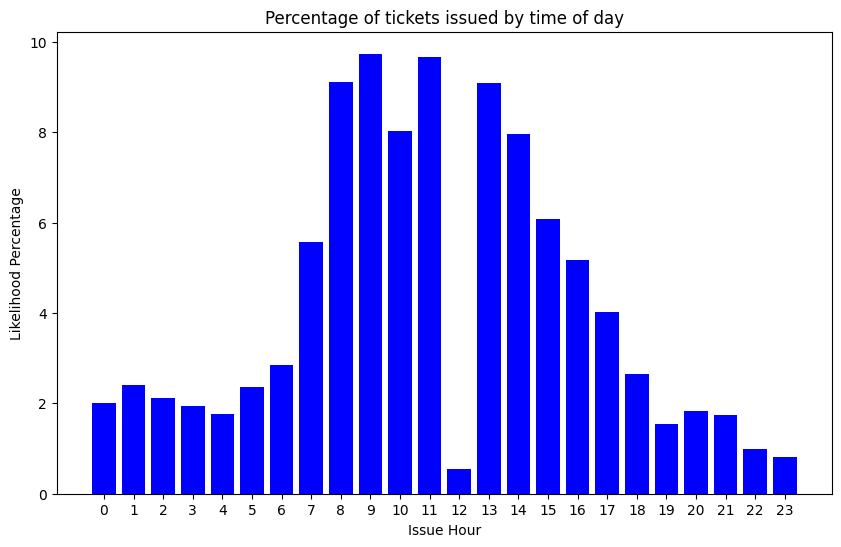

In [4]:
from pyspark.sql.functions import hour, col
import matplotlib.pyplot as plt

# Extract hours.
df_with_hour = df.withColumn("issue_hour", hour(col("issue_datetime")))

# Tickets per hour.
hourly_ticket_counts = df_with_hour.groupBy("issue_hour").count()

# Hour with the highest amounts of tickets issued.
most_likely_hour = hourly_ticket_counts.orderBy(col("count").desc()).first()
most_likely_hour_of_day = most_likely_hour["issue_hour"]
ticket_count_at_peak_hour = most_likely_hour["count"]

# Calculate the total number of tickets for percentages.
total_tickets = df_with_hour.count()

# Calculate the percentage likelihood for each hour.
hourly_ticket_counts = hourly_ticket_counts.withColumn(
    "likeliness_percentage",
    (col("count") / total_tickets) * 100
)

# Show results.
print(f"The most likely hour of the day to get a ticket: {most_likely_hour_of_day}")
print(f"The number of tickets issued during that hour: {ticket_count_at_peak_hour}")

print("Count and likeliness to get a ticket for all hours of the day:")
hourly_ticket_counts.orderBy(hourly_ticket_counts.likeliness_percentage.desc()).show(24, truncate=False)

# Convert to pandas for plotting.
pandas_df = hourly_ticket_counts.orderBy('issue_hour').toPandas()

plt.figure(figsize=(10, 6))
plt.bar(pandas_df['issue_hour'], pandas_df['likeliness_percentage'], color='blue')
plt.xlabel('Issue Hour')
plt.ylabel('Likelihood Percentage')
plt.title('Percentage of tickets issued by time of day')
plt.xticks(range(0, 24))
plt.show()

The above analysis suggests that 9am is the hour with the highest probability of receiving a ticket in New York City. But it also shows that there is only a small difference between the number of tickets issued at 9am and 11am or 8am. 
It is very noticeable that all the early hours of a normal work day are ranked highest. It is interesting to note that the lowest number of tickets are issued between 12 and 13 o'clock.
This is surprising because the data suggests that more tickets are issued at 3 am in the morning than during the lunch hour.
Overall, the results seem reasonable, even if it is a bit unexpected to see that there are still so many tickets given at night and there is such a steep decline during the lunch break. It's also interesting to see how quickly the number of tickets issued drops from 1 pm onward.

## Question 4: Does the Pareto Principle apply? Do the top 20% of plate ids generate 80% of the revenue?

First Query is a lot faster but doesn't use as much the learned SQL commands

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as _sum

# Filter out invalid plate IDs and group by plate_id to count the tickets.
violator_ticket_counts = df.filter((col("plate_id") != "BLANKPLATE") & (col("plate_id") != "N/A")) \
    .groupBy("plate_id") \
    .count()

# Calculate the top 20% threshold using approxQuantile.
top_20_percent_count_threshold = violator_ticket_counts \
    .approxQuantile("count", [0.80], 0.01)[0]

# Filter the top 20% violators.
top_20_percent_violators = violator_ticket_counts \
    .filter(col("count") >= top_20_percent_count_threshold)

# Join with the original dataframe to get rows for top 20% violators.
top_20_percent_df = df.join(top_20_percent_violators, on="plate_id", how="inner")

# Calculate total fine amount for top 20% violators.
total_fine_top_20_percent = top_20_percent_df.agg(_sum("fine_amount").alias("total_fine")).collect()[0]["total_fine"]

# Calculate total fine amount for all violators.
total_fine_all = df.agg(_sum("fine_amount").alias("total_fine")).collect()[0]["total_fine"]

# Calculate the percentage.
percentage_fine_top_20_percent = (total_fine_top_20_percent / total_fine_all) * 100

print(percentage_fine_top_20_percent)

75.2081013971057


Approximately 75% of total violation revenue comes from the top 20% of highest paying plate IDs. This seems like a reasonable number. There are many plate IDs that have only a small number of minor violations over 10 years. But the top 20% of violators have violated a lot over the 10 years. So it makes sense that the top percentage would make up a big portion of the total revenue that comes from parking fines. This shows that the Pareto principle applies to parking violations. A small number of plates cause most parking violations. What's interesting is that we were able to show not only that a small amount pays a large percentage, but that it's even very close to the Pareto suggested 80%.

## Question 5: How much money do the top 10 most issued violations bring in?

In [6]:
from pyspark.sql.functions import col

# Group by violation code and sum the fine amount.
violation_counts = df.groupBy("violation_code", "violation_description") \
    .agg({"fine_amount": "sum"}) \
    .withColumnRenamed("sum(fine_amount)", "total_fine") \
    .orderBy(col("total_fine").desc()) \
    .limit(10)

In [7]:
def format_large_numbers(x, pos):
    if x >= 1e9:
        return '{:,.0f}B'.format(x * 1e-9)
    elif x >= 1e6:
        return '{:,.0f}M'.format(x * 1e-6)
    elif x >= 1e3:
        return '{:,.0f}K'.format(x * 1e-3)
    else:
        return '{:,.0f}'.format(x)

Codes:  [36, 14, 21, 40, 38, 46, 20, 71, 19, 7]
Descriptions:  ['PHTO SCHOOL ZN SPEED VIOLATION', 'NO STANDING-DAY/TIME LIMITS', 'NO PARKING-STREET CLEANING', 'FIRE HYDRANT', 'FAIL TO DSPLY MUNI METER RECPT', 'DOUBLE PARKING', 'NO PARKING-DAY/TIME LIMITS', 'INSP. STICKER-EXPIRED/MISSING', 'NO STANDING-BUS STOP', 'FAILURE TO STOP AT RED LIGHT']
Total Fines:  [1559547200.0, 1169243870.0, 1015908520.0, 769254780.0, 639667750.0, 631166575.0, 487466562.5, 396143605.0, 372928555.0, 302852300.0]


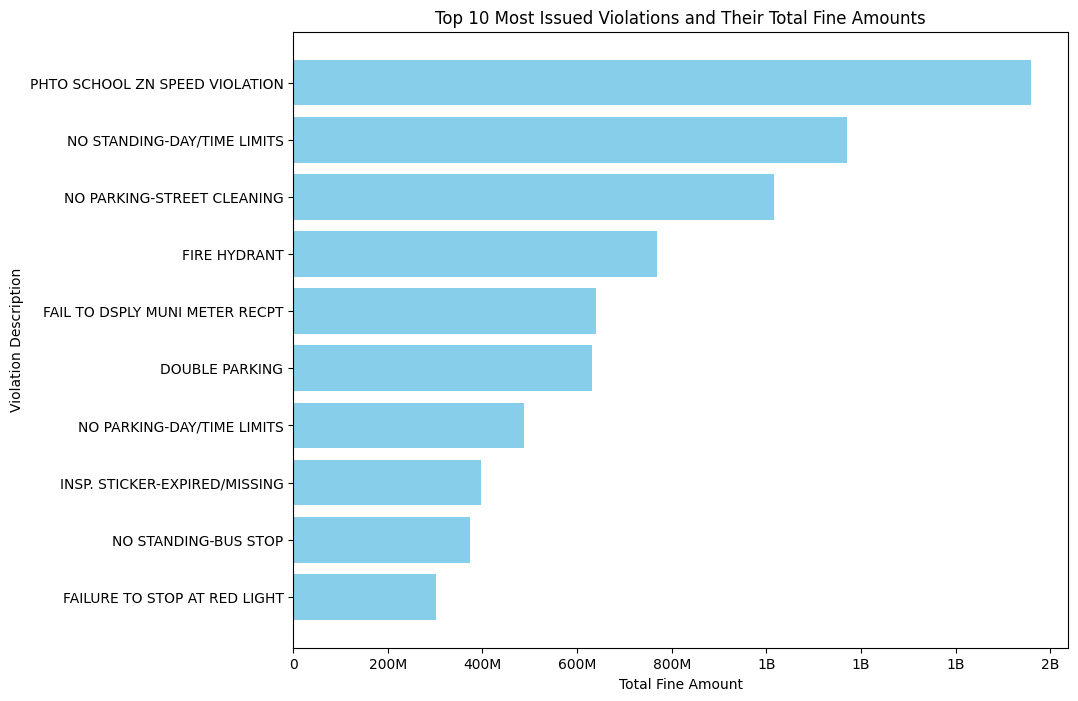

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Extracting data for plotting.
codes = violation_counts.select("violation_code").rdd.flatMap(lambda x: x).collect()
descriptions = violation_counts.select("violation_description").rdd.flatMap(lambda x: x).collect()
total_fines = violation_counts.select("total_fine").rdd.flatMap(lambda x: x).collect()

# Print the extracted data.
print("Codes: ", codes)
print("Descriptions: ", descriptions)
print("Total Fines: ", total_fines)

# Plotting.
plt.figure(figsize=(10, 8))
plt.barh(descriptions, total_fines, color='skyblue')
plt.xlabel('Total Fine Amount')
plt.ylabel('Violation Description')
plt.title('Top 10 Most Issued Violations and Their Total Fine Amounts')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest fine at the top
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_large_numbers))  # Apply the formatting function to x-axis
plt.show()

The "photo school zone speed violation" is the violation that has brought in about $2 billion since 2013. This is especially interesting when you consider that it is not one of the more expensive fines. The fine with the highest payment for a fine is 512 dollars and the "photo school zone speed violation" only costs 50 dollars. In conclusion, it must be an offense that is fined very often. It would make sense that the New York authorities would enforce more at high risk places like schools. Also, because speeding can be caught automatically by speed cameras, it makes sense that there were more such fines given. In this article, the New York authorities describe how they monitor schools for speeding. (https://www.nyc.gov/site/finance/vehicles/school-zone-camera-violations.page)

In [9]:
spark.stop()